# Описание исследования

Проводим работу с табличными данными, в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы. Нужно предсказать, какие из них закроются, а какие нет. Соревнование проводится на популярной платформе Kaggle, что позволит не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой. 

# Цель исследования

- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

# Этапы исследования

- Загрузка и ознакомление с данными
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

# Описание данных

Датасет состоит из двух файлов: 
- тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). 
- Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. 
Временной период - '1970-01-01' по '2018-01-01'. 
Дата формирования выгрузки - '2018-01-01'

- `kaggle_startups_train_27042024.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- `kaggle_startups_test_27042024.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- `kaggle_startups_sample_submit_27042024.csv` - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed']. 

**Описание полей данных**
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [1]:
! pip install phik -q
! pip install shap -q
! pip install scikit-learn==1.5.0 -q
! pip install seaborn==0.13.2 -q
! pip install missingno -q

In [2]:
import warnings

# Игнорировать предупреждения UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import os
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import phik  # noqa: F401

from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from matplotlib import rcParams, rcParamsDefault

In [4]:
# Устанавливает размер всех создаваемых графиков в дюймах
rcParams["figure.figsize"] = 8, 8
# отображать графики в формате SVG
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 1
# Получает значение DPI (точек на дюйм) по умолчанию для графиков.
default_dpi = rcParamsDefault["figure.dpi"]
# устанавливает значение DPI для графиков, умножая значение по умолчанию на factor
rcParams["figure.dpi"] = default_dpi * factor
# ограничивает максимальную ширину колонки
pd.options.display.max_colwidth = 50
# устанавливает максимальное количество отображаемых колонок
pd.options.display.max_columns = 50
# настройка отображения чисел с плавающей точкой
pd.set_option("display.float_format", "{:.3f}".format)

### Определение собственных функций

#### Функция для ознакомления с данными 

In [5]:
def preprocessing(df):
    print("Изучение данных датафрейма")
    print("Вывод первых 5 строк \n")
    display(df.head(5))
    print("-" * 100)
    print(f"Размерность датафрейма, составляет - {(df.shape)}")
    print("-" * 100)
    print("Общая информация:\n")
    display(df.info())
    print("-" * 100)
    print("Описательная статистика:\n")
    display(df.describe())
    print("-" * 100)
    df.isna().sum()
    print("Проверка на наличие явных дубликатов:\n")
    display(df.duplicated().sum())
    print("-" * 100)
    print("Вывод количества уникальных значений")
    display(pd.DataFrame(df.apply(lambda x: x.nunique())))

#### Функция заполнения данных медианой

In [6]:
def fill_with_median(group, category):
    # Если категория группы - 'Unknown', заполнение NaN значений глобальной медианой
    if category == "Unknown":
        return group.fillna(global_median)
    # Проверка наличия хотя бы одного не-NaN значения в группе
    elif group.notna().any():
        # Заполнение NaN значений медианой группы
        return group.fillna(group.median())
    else:
        # Заполнение NaN значений глобальной медианой
        return group.fillna(global_median)

## Загрузка и ознакомление с данными

In [7]:
pth1 = "./datasets/kaggle_startups_train_27042024.csv"
pth2 = "./datasets/kaggle_startups_test_27042024.csv"

if os.path.exists(pth1):
    # Тренировочная выборка:
    df_ks_train = pd.read_csv(
        pth1,
        parse_dates=["founded_at", "first_funding_at", "last_funding_at", "closed_at"],
    )
    if os.path.exists(pth2):
        # Тестовая выборка:
        df_ks_test = pd.read_csv(
            pth2, parse_dates=["founded_at", "first_funding_at", "last_funding_at"]
        )
    else:
        print("Something is wrong")

Выведем первоначальную информацию о датафрейме с тренировочными данными

In [8]:
preprocessing(df_ks_train)

Изучение данных датафрейма
Вывод первых 5 строк 



,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


----------------------------------------------------------------------------------------------------
Размерность датафрейма, составляет - (52514, 13)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at 

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,42445.000,52514.000,52514,52514,52514,4915
mean,18248255.980,1.741,2008-11-04 08:35:44.342460928,2011-07-17 04:55:32.779830016,2012-06-27 16:46:47.936931072,2012-01-17 17:10:42.360121856
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-12-19 00:00:00
25%,336000.000,1.000,2006-09-28 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-10-01 12:00:00
50%,2000000.000,1.000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-10-01 00:00:00
75%,10000000.000,2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-30 12:00:00
max,30079503000.000,19.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-11-12 00:00:00
std,187121675.710,1.375,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений


,0
name,52513
category_list,22108
funding_total_usd,15551
status,2
country_code,134
state_code,300
region,1036
city,4477
funding_rounds,19
founded_at,5401


Посмотрим количество пропусков в тренировочных данных

In [9]:
nan_counts = df_ks_train.isna().sum()
print(nan_counts)

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


In [10]:
# Создание объекта осей
fig, ax = plt.subplots(figsize=(18, 4))
# Генерация графика с использованием объекта осей
msno.matrix(df_ks_train, ax=ax, sparkline=False)
# Добавление названия графика
ax.set_title("Матрица пропущенных значений")
# Отображение графика
plt.show()

**Что можно сказать из первоначальных данных:**
- `name` - имеет 1 пропуск, удалим так как он не испорит общую картину
- `category_list`   - список категорий -  имеет большое количество пропусков, подумаем что с ними можно сделать - 2465, возможно просто внесем категорию Unknown, так же имеет огромное количество категорий, но множество из них разделено знаком |, предлагаю удалить данные после данного символа и оставить название категории до вышеуказанного символа. Позволит уменьшить количество уникальных категорий.
*После проведения обучения и определения важности признаков было принято решение вообще удалить данный столбец*
- `funding_total_usd`   - Общая сумма финансирования в USD - тоже множество пропусков  - 10069, предлагаю заполнить медианными значениями по группе страны нахождения. Не имеющие данных либо категорию неизвестно - заполнить глобальным медианным значением.
- `status`   - статус. Не имеет проблем в данных. Это наш целевой признак.
- `country_code`     - код старны - имеет много пропусков 5501, чем заполнить пока не ясно, оставим, так же имеет не так много категорий, переведем в категориальный тип. Предлагаю заполнить категорией Unknown, а те коды группа которых составляет меньше 10 - сделать как - Other.
- `state_code`      state_code - Код штата    имеет много пропусков  6762, чем заполнить пока не ясно, оставим, так же имеет не большое количество категорий, переведем в категориальный тип. Думаю данная колонка не нужна нам для обучения модели, так как согласно матрице пропусков, это все географические названия и пропуски связаны между собой. Для обучения будем использовать код страны.
- `region`        - региона, много пропусков -  6358, и много категорий. Думаю дальше данные эти не понадобятся для обучения модели, оставим пропуски. Думаю данная колонка не нужна нам для обучения модели, так как согласно матрице пропусков, это все географические названия и пропуски связаны между собой. Для обучения будем использовать код страны
- `city`           - город, много пропусков -        6358, соответствует данным по региону. Вообще все пропуски связанные с географическим положением не заполнены в одинх и теж же строках, это можно наглядно увидеть по матрице пропусков. Возможно кто то заполнял только код страны, а остальные данные были не обязательны для заполнения, либо данные о них просто отсутствовали. Думаю данная колонка не нужна нам для обучения модели, так как согласно матрице пропусков, это все географические названия и пропуски связаны между собой. Для обучения будем использовать код страны 
- `funding_rounds`  -   Количество раундов финансирования    - Не имеет проблем в данных. Только переведем в int, так как даные числовые.
- `founded_at`       -    Дата основания    - Не имеет проблем в данных.
- `first_funding_at`  -     Дата первого раунда финансирования - Не имеет проблем в данных.
- `last_funding_at`    -      Дата последнего раунда финансирования - Не имеет проблем в данных.
- `closed_at`        -    Дата закрытия стартапа (если применимо) - имеет большое количество пропусков - 47599, что может говорит о том, что большинство из представленных в данных стартапов являются действующими. Данная колонка будет мешать предсказанию, так как нам надо именно предсказать будет ли закрыт стартап или нет, и оставив ее мы получим утечку целевого признака, поэтому заполним пропуски датой выгрузки данных и создадим новую синтетическую информацию, а именно `lifetime` - Время существования стартапа в днях, для этого посчитаем количество дней прошедших между датой основания и датой закрытия
Так же создадим еще несколько синтетичеческих признаков 
- какое количество дней прошло между созданием стартапа и получения первого финансирования - `first money` 
- как часто финансироался стартам, для этого разницу между 1 и последним раундом финансирования разделим на количество раундов финансирования - `frequency_financing`

## Предварительная обработка даных

### Приведение типов данных

In [11]:
df_ks_train = df_ks_train.astype(
    {"funding_rounds": np.int32, "funding_total_usd": np.float32}
)
df_ks_train[df_ks_train.select_dtypes(["object"]).columns] = df_ks_train.select_dtypes(
    ["object"]
).apply(lambda x: x.astype("category"))
df_ks_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  category      
 1   category_list      50049 non-null  category      
 2   funding_total_usd  42445 non-null  float32       
 3   status             52514 non-null  category      
 4   country_code       47013 non-null  category      
 5   state_code         45752 non-null  category      
 6   region             46156 non-null  category      
 7   city               46156 non-null  category      
 8   funding_rounds     52514 non-null  int32         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: category(7), datetime64[ns](4), float32(1), int32(1)
memor

### Работа с пропусками

#### **Поработаем с пропусками в колонке name**

In [12]:
missing_name_row = df_ks_train[df_ks_train["name"].isna()]
missing_name_row

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.000,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-03-31


Удалим ее и сбросим индексы

In [13]:
df_ks_train = df_ks_train.dropna(subset=["name"]).reset_index(drop=True)

In [14]:
# Проверим на пропуски
df_ks_train.isnull().sum()

name                     0
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

#### **Поработаем с колонкой category_list**

***Проведя обучение модели и выявив важность признаков в предыдущей итерации, получен вывод о том что данная колонка вообще не является важной, признаков очень много они разные и не особо влияют на обучение. Попробуем радикальный метод - удаление.***

In [15]:
df_ks_train = df_ks_train.drop("category_list", axis=1)

In [16]:
df_ks_train.head(5)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,22250000.000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


#### **Поработаем с колонкой status**

In [17]:
# Проверим на пропуски
df_ks_train.status.isnull().sum()

0

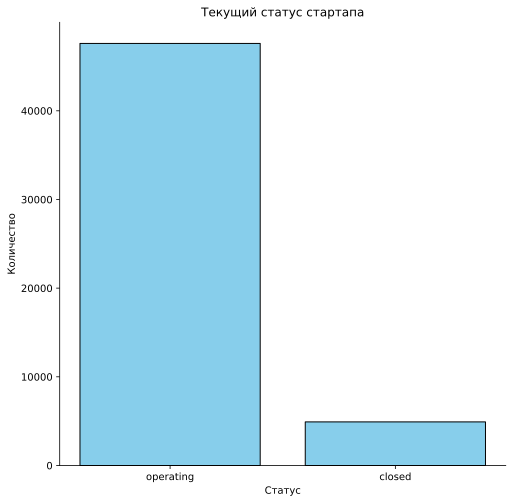

In [18]:
category_counts = df_ks_train.status.value_counts()
plt.bar(
    category_counts.index, category_counts.values, color="skyblue", edgecolor="black"
)

# Добавляем название диаграммы и осей
plt.title("Текущий статус стартапа")
plt.xlabel("Статус")
plt.ylabel("Количество")

# Отображаем график
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

Пропущенных значений нет, большинство стартапов являются действующими

#### **Поработаем с колонкой country_code**

In [19]:
unique_categories_country_code = df_ks_train["country_code"].nunique()
unique_categories_country_code

134

In [20]:
new_var = df_ks_train["country_code"].unique()
new_var

['CHE', 'USA', NaN, 'GBR', 'RUS', ..., 'SOM', 'CMR', 'MNE', 'SYC', 'ZMB']
Length: 135
Categories (134, object): ['ALB', 'ARE', 'ARG', 'ARM', ..., 'VNM', 'ZAF', 'ZMB', 'ZWE']

Заменим пропуски на заглушку 'Unknown'

In [21]:
# Добавляем 'Unknown' в категории
df_ks_train["country_code"] = df_ks_train["country_code"].cat.add_categories(
    ["Unknown"]
)

# Заменяем NaN на 'Unknown'
df_ks_train["country_code"] = df_ks_train["country_code"].fillna("Unknown")

Посчитаем количество уникальных значений в каждой категории

In [22]:
counts = df_ks_train["country_code"].value_counts()
counts

country_code
USA        29700
Unknown     5501
GBR         2925
CAN         1540
IND         1276
           ...  
MNE            1
NIC            1
OMN            1
QAT            1
TGO            1
Name: count, Length: 135, dtype: int64

Снова видим много стран имеющих только по 1 включению, используем тот же подход и заменим на Other, используя порог 4, чтоб наши данные в последующем корректно разделились между тестовой и тренировочными выборками

In [23]:
df_ks_train["country_code"] = df_ks_train["country_code"].apply(
    lambda x: "Other" if counts[x] < 4 else x
)

In [24]:
df_ks_train["country_code"].nunique()

84

Построим график ТОП-10 Кодов стран, без учета "Unknown"

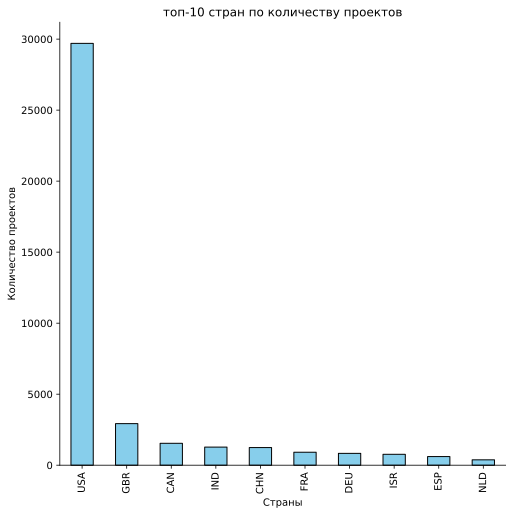

In [25]:
# Фильтруем DataFrame, чтобы исключить строки с 'Unknown'
filtered_df = df_ks_train[df_ks_train["country_code"] != "Unknown"]
# Подсчитываем количество проектов по странам, исключая 'Unknown'
country_counts = filtered_df["country_code"].value_counts().head(10)
# Строим график топ-10 стран по количеству проектов
country_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("топ-10 стран по количеству проектов")
plt.xlabel("Страны")
plt.ylabel("Количество проектов")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

Снизили количество категорий с 134 до 84

#### **Поработаем с колонкой state_code**

In [26]:
unique_categories_state_code = df_ks_train["state_code"].nunique()
unique_categories_state_code

300

In [27]:
df_ks_train["state_code"].unique()

['25', 'CA', NaN, 'VA', 'NJ', ..., 'M8', 'J3', 'NU', 'V5', 'U6']
Length: 301
Categories (300, object): ['1', '10', '11', '12', ..., 'Y9', 'Z1', 'Z7', 'Z8']

Имеем множество уникальных значений, где есть и цифры и буквы и их комбинации. Попробуем уменьшить их количество объединив наиболее мелкие категории содержащие до 10 значений в одну категорию Other

In [28]:
counts = df_ks_train["state_code"].value_counts()
threshold = 10  # Порог
df_ks_train["state_code"] = df_ks_train["state_code"].apply(
    lambda x: "Other" if counts[x] < threshold else x
)

In [29]:
df_ks_train["state_code"].nunique()

169

Получили существенное уменьшение категорий, заполним пропуски значением Unknown. Полагаю что данная колонка не понадобится  нам для обучения, поэтому можно просто поставить заглушку чтоб сохранить данные в других столбцах

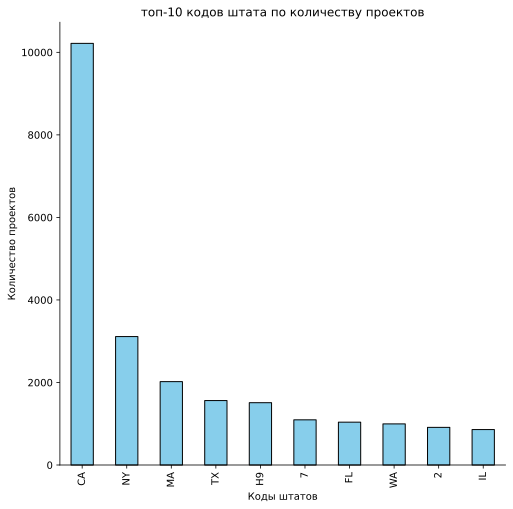

In [30]:
# Фильтруем DataFrame, чтобы исключить строки с 'Unknown' и 'Other'
filtered_df_2 = df_ks_train[
    (df_ks_train["state_code"] != "Other") & (df_ks_train["state_code"] != "Unknown")
]
# Подсчитываем количество проектов по странам, исключая 'Unknown' и 'Other'
state_counts = filtered_df_2["state_code"].value_counts().head(10)
# Строим график топ-10 по количеству проектов
state_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("топ-10 кодов штата по количеству проектов")
plt.xlabel("Коды штатов")
plt.ylabel("Количество проектов")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

Открытые источники говорят что код штата СА - Калифорния, NY - Нью-Йорк, а МА - Массачусетс
В принципе ТОП 3 кодов штатов, подтверждает предыдущий график, что больше всего стартапов в США, и уже внутри США самым оживленным по стартапам является Калифорния

#### **Поработаем с колонкой funding_total_usd**

In [31]:
df_ks_train["funding_total_usd"].describe()

count         42444.000
mean       18248684.000
std       187123856.000
min               1.000
25%          336041.250
50%         2000000.000
75%        10000000.000
max     30079502336.000
Name: funding_total_usd, dtype: float64

Видим явный выброс, как значение 30 079 502 336, при том что медиана у нас всего 2 000 000 долларов, предлагаю посмотреть значения которые выпадают за 99 квантиль и тоже удалить их, так как это будет не более 1% от выборки, а данные существенно улучшатся

 значения выше чем 220000000.0 выпадают за 99 квантиль их количество составляет 424


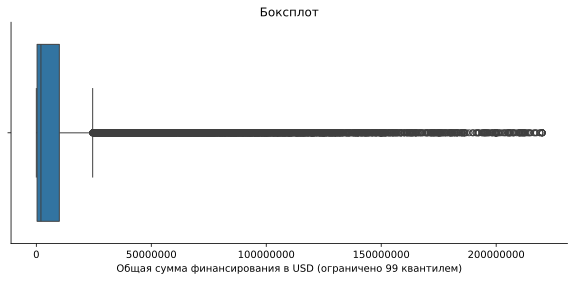

In [32]:
# Вычисление 99-го квантиля для столбца 'funding_total_usd'
quantile_99 = df_ks_train["funding_total_usd"].quantile(0.99)
print(
    f' значения выше чем {quantile_99} выпадают за 99 квантиль их количество составляет {len(df_ks_train.loc[df_ks_train["funding_total_usd"] > quantile_99])}'
)
# Создание боксплота с ограничением данных 99-м квантилем
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(
    x="funding_total_usd",
    data=df_ks_train[df_ks_train["funding_total_usd"] <= quantile_99],
    orient="h",
    ax=ax,
)
ax.ticklabel_format(style="plain", axis="x")
ax.set_title("Боксплот")
ax.set_xlabel("Общая сумма финансирования в USD (ограничено 99 квантилем)")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

In [33]:
df_ks_train = df_ks_train[
    (df_ks_train["funding_total_usd"] <= quantile_99)
    | (df_ks_train["funding_total_usd"].isna())
]

После удаления значений выпадающих за 99 квантиль заполним оставщиеся значения по следующему принципу.
Заполним пропущенные данные медианой по группе стран (придерживаюсь теории что объем финансирования в разных странах для стартапов разный, стартап в США это не тоже самое что стартап в ЮАР).  Так как мы не знаем в какие категории могли попасть в 'Unknown', то заполним ее не медианой по группе 'Unknown', а глобальной медианой, для этого:
Создадим функцию fill_with_median которая проверяет, равна ли категория - 'Unknown', и если это так, то она заполняет пропущенные значения в funding_total_usd глобальной медианой. Это гарантирует, что для категории 'Unknown' всегда будет использоваться глобальная медиана, а не медиана по группе 'Unknown'. Для остальных значений сначала проверяет есть ли в группе хоть 1 значение, если есть заполняет медианой по группе, в противном случае глобальной медианой.

In [34]:
# Вычисление глобальной медианы для столбца 'funding_total_usd'
global_median = df_ks_train["funding_total_usd"].median()

# Применение функции fill_with_median к каждой группе в столбце 'category_list'
df_ks_train["funding_total_usd"] = df_ks_train.groupby("country_code")[
    "funding_total_usd"
].transform(lambda x: fill_with_median(x, x.name))

In [35]:
df_ks_train.isna().sum()

name                     0
funding_total_usd        0
status                   0
country_code             0
state_code            6727
region                6326
city                  6326
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47192
dtype: int64

## Разработка новых синтетических признаков

**Создание признака lifetime - Время существования стартапа в днях**

Заполним closed_at датой выгрузки данных, для последующего создания столбца lifetime - Время существования стартапа в днях

In [36]:
df_ks_train["closed_at"] = df_ks_train["closed_at"].fillna(datetime(2018, 1, 1))

In [37]:
df_ks_train["lifetime"] = (df_ks_train["closed_at"] - df_ks_train["founded_at"]).dt.days
df_ks_train.head(5)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,2923
1,EarLens,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,22250000.000,operating,Unknown,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,2841879.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,2650


closed_at	нам больше не нужен, удалим его

In [38]:
df_ks_train = df_ks_train.drop("closed_at", axis=1)

Проверим, что все удалилось, а нужные нам столбцы остались

In [39]:
df_ks_train.head(5)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Lunchgate,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2923
1,EarLens,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,4748
2,Reviva Pharmaceuticals,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,4383
3,Sancilio and Company,22250000.000,operating,Unknown,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,5114
4,WireTough Cylinders,2841879.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2650


**Создадим новый признак который бы показывал какое количество дней прошло между созданием стартапа и получения первого финансирования - first money**

In [40]:
df_ks_train["first_money"] = (
    df_ks_train["first_funding_at"] - df_ks_train["founded_at"]
).dt.days
df_ks_train.head(5)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,first_money
0,Lunchgate,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2923,486
1,EarLens,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,4748,1949
2,Reviva Pharmaceuticals,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,4383,2423
3,Sancilio and Company,22250000.000,operating,Unknown,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,5114,2800
4,WireTough Cylinders,2841879.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2650,489


**Создадим новый признак который бы показывал как часто финансироался стартам, для этого разницу между 1 и последним раундом финансирования разделим на количество раундов финансирования - frequency_financing**

In [41]:
df_ks_train["frequency_financing"] = (
    (df_ks_train["last_funding_at"] - df_ks_train["first_funding_at"]).dt.days
) / df_ks_train["funding_rounds"]
df_ks_train.head(5)

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,first_money,frequency_financing
0,Lunchgate,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2923,486,655.000
1,EarLens,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,4748,1949,348.250
2,Reviva Pharmaceuticals,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,4383,2423,227.000
3,Sancilio and Company,22250000.000,operating,Unknown,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,5114,2800,350.333
4,WireTough Cylinders,2841879.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2650,489,0.000


In [42]:
df_ks_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52089 entries, 0 to 52512
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 52089 non-null  category      
 1   funding_total_usd    52089 non-null  float32       
 2   status               52089 non-null  category      
 3   country_code         52089 non-null  object        
 4   state_code           45362 non-null  object        
 5   region               45763 non-null  category      
 6   city                 45763 non-null  category      
 7   funding_rounds       52089 non-null  int32         
 8   founded_at           52089 non-null  datetime64[ns]
 9   first_funding_at     52089 non-null  datetime64[ns]
 10  last_funding_at      52089 non-null  datetime64[ns]
 11  lifetime             52089 non-null  int64         
 12  first_money          52089 non-null  int64         
 13  frequency_financing  52089 non-null 

Итак у нас дополнительно создано 3 синтетических признака, которые должны помочь в обучении модели

## Немного визуализаций

**Посмотрим визуализации изменения количества раундов финансирования компаний в зависимости от даты их основания**

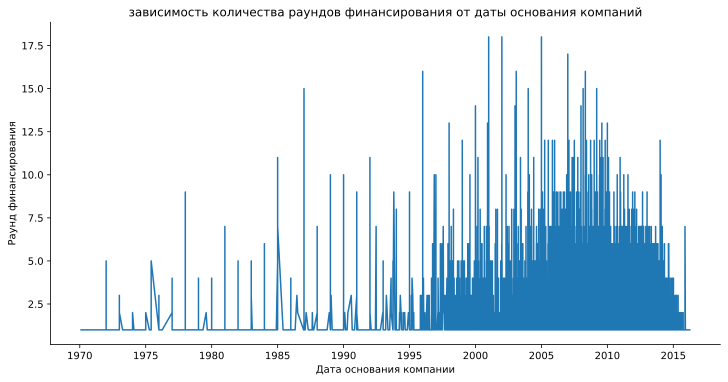

In [43]:
def plot_series(series):
    xs = series["founded_at"]
    ys = series["funding_rounds"]
    plt.plot(xs, ys)


fig, ax = plt.subplots(figsize=(10, 5.2), layout="constrained")
df_sorted = df_ks_train.sort_values("founded_at", ascending=True)
plot_series(df_sorted)
sns.despine(fig=fig, ax=ax)
plt.xlabel("Дата основания компании")
plt.ylabel("Раунд финансирования")
plt.title("зависимость количества раундов финансирования от даты основания компаний")
plt.show()

Данный график может сказать, что компании в основном имеют до 7 раундов финансирования, а большая часть финансирования началась для компаний созданных после 2000 года

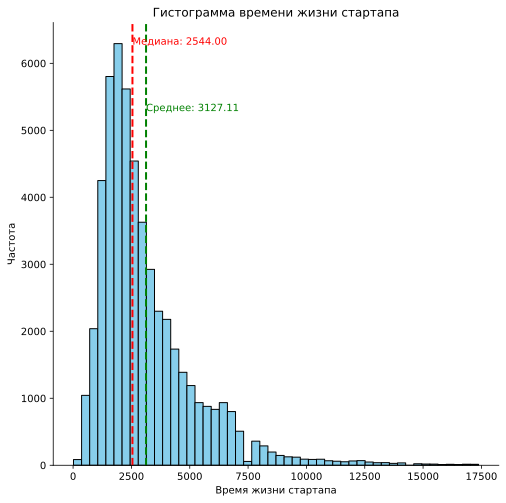

In [44]:
df_ks_train["lifetime"].plot(
    kind="hist",
    bins=50,
    title="Гистограмма времени жизни стартапа",
    color="skyblue",
    edgecolor="black",
)

# Расчет медианы и среднего
median_value = df_ks_train["lifetime"].median()
mean_value = df_ks_train["lifetime"].mean()

# Добавление линии медианы
plt.axvline(median_value, color="red", linestyle="dashed", linewidth=2)
# Добавление линии среднего значения
plt.axvline(mean_value, color="green", linestyle="dashed", linewidth=2)

# Добавление текста для медианы и среднего значения
plt.text(
    median_value,
    plt.gca().get_ylim()[1] * 0.95,
    f"Медиана: {median_value:.2f}",
    color="red",
)
plt.text(
    mean_value,
    plt.gca().get_ylim()[1] * 0.8,
    f"Среднее: {mean_value:.2f}",
    color="green",
)

# Остальная часть вашего кода
plt.xlabel("Время жизни стартапа")
plt.ylabel("Частота")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

Исходя из данной гистограммы видим что время жизни стартапа в основном составляет около 2000 дней, что достаточно много, так же наблюдаются стартапы долгожители более 10 000 дней

## **Проведем корреляционный анализ данных, проверив данные на мультиколлинеарность**

Используем библиотеку FINK, но исключим данные связанные датами, такими как дата основания, первый и последний раунд финансирования. Основна временная позиция - это время жизни стартапа, думаю это будет основа нашего будущего предсказания.   
*P.S. Если использовать все данные в таблице, расчет проводиться очень долго.*

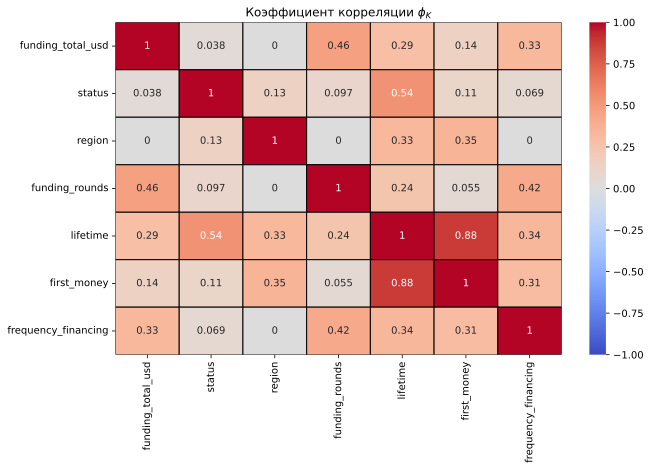

In [45]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_ks_train.drop(
        [
            "name",
            "state_code",
            "country_code",
            "city",
            "founded_at",
            "first_funding_at",
            "last_funding_at",
        ],
        axis=1,
    ).phik_matrix(verbose=False),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    linewidths=1,
    linecolor="black",
)
plt.title("Коэффициент корреляции $\phi_K$")
plt.show()

Наибольшую взаимосвязь видим между целевым признаком количеством дней жизни стартапа - 0,54.

Так же имеется достаточно сильная взаимосвязь между временем жизни стартапа и количеством дней до первой даты финансирования - 0,88

При мультиколлинеральноси имеются взаимосвязи т 0.9 до 0.95 по модулю. 

## Отбор финального набора обучающих признаков

- status  - целевой признак
- funding_total_usd - объем финансирования
- country_code - код страны
- funding_rounds - раунд финансирования
- lifetime - время жизни стартапа
- first_money - получение первого финансирования
- frequency_financing  - частота получения финансирования

In [46]:
feature = [
    "name",
    "status",
    "funding_total_usd",
    "country_code",
    "funding_rounds",
    "lifetime",
    "first_money",
    "frequency_financing",
]

Создадим датафрейм содержащий только данные столбцы для обучения

In [47]:
df_train = df_ks_train[feature].copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52089 entries, 0 to 52512
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   name                 52089 non-null  category
 1   status               52089 non-null  category
 2   funding_total_usd    52089 non-null  float32 
 3   country_code         52089 non-null  object  
 4   funding_rounds       52089 non-null  int32   
 5   lifetime             52089 non-null  int64   
 6   first_money          52089 non-null  int64   
 7   frequency_financing  52089 non-null  float64 
dtypes: category(2), float32(1), float64(1), int32(1), int64(2), object(1)
memory usage: 5.0+ MB


Убедимся что у нас не осталось пропусков в значениях необходимых для обучения

In [48]:
df_train.isna().sum()

name                   0
status                 0
funding_total_usd      0
country_code           0
funding_rounds         0
lifetime               0
first_money            0
frequency_financing    0
dtype: int64

## Проведение аналогичной предобработки данных на тестовых (приведение к одному виду и размерности)

In [49]:
preprocessing(df_ks_test)

Изучение данных датафрейма
Вывод первых 5 строк 



,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.000,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.000,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.000,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.000,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


----------------------------------------------------------------------------------------------------
Размерность датафрейма, составляет - (13125, 12)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   founded_at         13125 non-null  datetime64[ns]
 9   first_fundi

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
count,10547.000,13125.000,13125,13125,13125,13125.000
mean,16549102.695,1.714,2008-12-10 20:55:47.382856960,2011-07-23 20:54:08.640000,2012-06-16 05:03:41.348571392,3098.206
min,1.000,1.000,1971-01-01 00:00:00,1973-04-15 00:00:00,1973-04-15 00:00:00,79.000
25%,320000.000,1.000,2007-01-01 00:00:00,2009-11-16 00:00:00,2011-01-10 00:00:00,1729.000
50%,2000000.000,1.000,2010-10-21 00:00:00,2012-08-01 00:00:00,2013-08-21 00:00:00,2526.000
75%,10000000.000,2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-11 00:00:00,3871.000
max,4715000000.000,15.000,2015-11-17 00:00:00,2015-12-03 00:00:00,2015-12-12 00:00:00,17167.000
std,92172825.632,1.319,NaN,NaN,NaN,2128.489


----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений


,0
name,13125
category_list,6206
funding_total_usd,4549
country_code,96
state_code,235
region,688
city,2117
funding_rounds,15
founded_at,3165
first_funding_at,3299


In [50]:
nan_counts_test = df_ks_test.isna().sum()
nan_counts_test

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Имеются пропуски в используемых для обучения аналогичных колонках 
- category_list         591
- funding_total_usd    2578
- country_code         1382  

Так как строки удалять нельзя (заполним пропуски)

- category_list       - первым значением по категориям, остальные категорией Unknown
- funding_total_usd    - медианным значением по категории
- country_code         - категорией Unknown

In [51]:
df_ks_test = df_ks_test.drop("category_list", axis=1)

In [52]:
# Заменяем NaN на 'Unknown'
df_ks_test["country_code"] = df_ks_test["country_code"].fillna("Unknown")

In [53]:
# Применение функции fill_with_median к каждой группе в столбце 'category_list'
df_ks_test["funding_total_usd"] = df_ks_test.groupby("country_code")[
    "funding_total_usd"
].transform(lambda x: fill_with_median(x, x.name))

In [54]:
df_ks_test.isna().sum()

name                    0
funding_total_usd       0
country_code            0
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

#### **Создаем новые синтетические признаки из имеющихся, аналогичные тренировочному датасету**

In [55]:
df_ks_test["first_money"] = (
    df_ks_test["first_funding_at"] - df_ks_test["founded_at"]
).dt.days
df_ks_test["frequency_financing"] = (
    (df_ks_test["last_funding_at"] - df_ks_test["first_funding_at"]).dt.days
) / df_ks_test["funding_rounds"]
df_ks_test.isna().sum()

name                      0
funding_total_usd         0
country_code              0
state_code             1695
region                 1589
city                   1587
funding_rounds            0
founded_at                0
first_funding_at          0
last_funding_at           0
lifetime                  0
first_money               0
frequency_financing       0
dtype: int64

Для поддержания размерности оставить в тестовом датфрейме только столбцы аналогичные тренировочному (за исключением статус - его мы предсказываем)

In [56]:
feature_test = [
    "name",
    "funding_total_usd",
    "country_code",
    "funding_rounds",
    "lifetime",
    "first_money",
    "frequency_financing",
]
df_test = df_ks_test[feature_test].copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 13125 non-null  object 
 1   funding_total_usd    13125 non-null  float64
 2   country_code         13125 non-null  object 
 3   funding_rounds       13125 non-null  int64  
 4   lifetime             13125 non-null  int64  
 5   first_money          13125 non-null  int64  
 6   frequency_financing  13125 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 717.9+ KB


Проверим размерость тествого и тренировочно, разница должна быть в один столбец (статус еще не создан в тестовом)

In [57]:
display(df_train.shape)
df_test.shape

(52089, 8)

(13125, 7)

## Выбор и обучение моделей

Так как данные несбалансированы, используем stratify=y, обеспечивая, что каждая выборка будет иметь представительное распределение классов, позволяя модели обучаться и тестироваться на данных, которые лучше отражают реальное распределение классов в исходном наборе данных. Это помогает улучшить надежность и обобщаемость модели машинного обучения.

In [58]:
# Фичи для обучения
X = df_train.drop(["name", "status"], axis=1)
y = df_train["status"]  # Метки классов

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [59]:
categorical_features = [
    # "category_list",
    "country_code"
]
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()

### Используем Pipeline для обучения модели

ПЕРЕБОР МОДЕЛЕЙ

In [60]:
# Создадим препроцессор - предварительный обработчик данных с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

In [61]:
# Создадим итоговый пайплайн куда будем передавать предобработчик и модели с разными параметрами
pipe_final = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("models", DecisionTreeClassifier(random_state=42)),
    ]
)

In [62]:
param_distributions = [
    # словарь для модели HistGradientBoostingClassifier
    {
        "models": [HistGradientBoostingClassifier()],
        "models__max_iter": range(100, 150),
        "models__learning_rate": [0.001, 0.01, 0.05, 0.1],
        "models__max_depth": range(3, 5),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
    # словарь для модели DecisionTreeClassifier()
    {
        "models": [DecisionTreeClassifier(random_state=42)],
        "models__max_depth": range(2, 6),
        "models__max_features": range(2, 6),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
    # словарь для модели LogisticRegression()
    {
        "models": [
            LogisticRegression(random_state=42, solver="liblinear", penalty="l1")
        ],
        "models__C": range(1, 10),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
    # словарь для модели GradientBoostingClassifier
    {
        "models": [GradientBoostingClassifier(random_state=42)],
        "models__n_estimators": (50, 150),
        "models__learning_rate": (0.1, 1),
        "models__max_depth": (3, 6),
        "models__min_samples_split": (2, 4),
        "models__min_samples_leaf": (1, 3),
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
    # словарь для модели CatBoostClassifier
    {
        "models": [CatBoostClassifier(random_state=42, silent=True)],
        "models__depth": range(2, 6),
        "models__learning_rate": [0.03, 0.1, 0.3],
        "models__iterations": [100, 200, 300],
        "preprocessor__num": [StandardScaler(), MinMaxScaler(), "passthrough"],
    },
]

In [63]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    scoring="f1_weighted",
    random_state=42,
    n_jobs=-1,
)

In [64]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['funding_total_usd',
                                                                                'funding_rounds',
                                                                                'lifetime',
                                                                                'first_money',
                                                                                'frequency_financing']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['country_code'])])),
                                             ('models',
                                              DecisionTree...
                                         'models__n_estimators': (50, 150),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x3119ecbb0>],
                                         'models__depth': range(2, 6),
                                         'models__iterations': [100, 200, 300],
                                         'models__learning_rate': [0.03, 0.1,
                                                                   0.3],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='f1_weighted')

In [65]:
# Используем лучшую найденную модель для предсказания
preds = randomized_search.predict(X_test)
f1 = f1_score(y_test, preds, average="weighted")
print(f"Метрика F1 на тестовой выборке: {f1}")

Метрика F1 на тестовой выборке: 0.9889095362939164


In [66]:
print("Лучшая модель и её параметры:")
display(randomized_search.best_estimator_)
print("Лучшие параметры модели:", randomized_search.best_params_)
print("Метрика лучшей модели на тренировочной выборке:", randomized_search.best_score_)

Лучшая модель и её параметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
                                                   'first_money',
                                                   'frequency_financing']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['country_code'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x311a08130>)])

Лучшие параметры модели: {'preprocessor__num': MinMaxScaler(), 'models__learning_rate': 0.3, 'models__iterations': 100, 'models__depth': 5, 'models': <catboost.core.CatBoostClassifier object at 0x3119ecbb0>}
Метрика лучшей модели на тренировочной выборке: 0.9879337213637506


In [67]:
pd.DataFrame(randomized_search.cv_results_)[
    ["params", "std_test_score", "rank_test_score", "param_models", "mean_test_score"]
].sort_values("rank_test_score").head(3)

,params,std_test_score,rank_test_score,param_models,mean_test_score
1,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.001,1,<catboost.core.CatBoostClassifier object at 0x...,0.988
0,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.002,2,HistGradientBoostingClassifier(),0.985
4,"{'preprocessor__num': 'passthrough', 'models__...",0.002,3,HistGradientBoostingClassifier(),0.985


In [68]:
best_model = (
    randomized_search.best_estimator_
)  # вот это лучшая модель (preprocessor + estimator), уже обученая.
regressor = best_model.named_steps["models"]  # Это отдельно модель
preprocessor = best_model.named_steps["preprocessor"]  # Это препроцессор

### Проверим адекватность модели с помощью Dummy модели

In [69]:
# Обучение DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

In [70]:
print("DummyClassifier F1 Score:", f1_score(y_test, dummy_pred, average="weighted"))
print("Лучшая модель дает -  F1 Score:", f1_score(y_test, preds, average="weighted"))

DummyClassifier F1 Score: 0.8613585697924457
Лучшая модель дает -  F1 Score: 0.9889095362939164


Результаты показывают, что наша модель имеет F1-меру 0.988, что значительно выше, чем F1-мера DummyClassifier, равная 0.861. Это указывает на то, что CatBoostClassifier работает лучше, чем простой классификатор, который делает предсказания, основываясь только на самом распространенном классе.

F1-мера является гармоническим средним между точностью и полнотой, и она особенно полезна, когда распределение классов несбалансировано.     
Высокое значение F1-меры для CatBoostClassifier говорит о том, что модель хорошо справляется с балансом между точностью и полнотой, что делает ее адекватной для нашей задачи классификации.

### Определение важности признаков

In [71]:
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

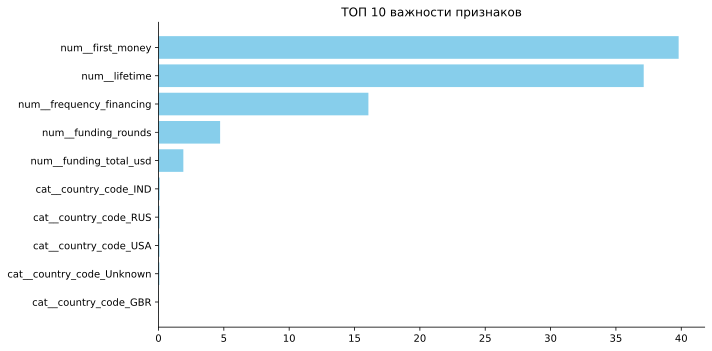

In [72]:
feature_importance = regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Вывод и визуализация ТОП 10 важности признаков
top_features = np.array(feature_names)[sorted_idx][
    -10:
]  # [-10:] для получения последних 10 элементов
plt.figure(figsize=(10, 5))
plt.title("ТОП 10 важности признаков")
plt.barh(
    top_features, feature_importance[sorted_idx][-10:], align="center", color="skyblue"
)
plt.xticks(rotation=0)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()

### Определение важности признаков с помощью библиотеки SHAP

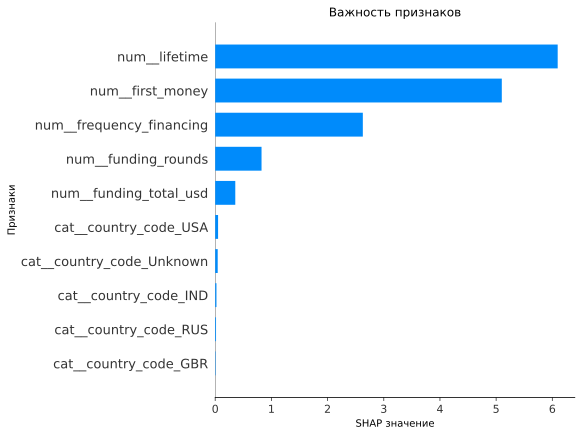

In [73]:
# Инициализация объекта SHAP Explainer
explainer = shap.TreeExplainer(regressor)
# Вычисление SHAP значений для тестового набора данных
shap_values = explainer.shap_values(preprocessor.transform(X_test))
# Визуализация важности признаков
shap.summary_plot(
    shap_values,
    preprocessor.transform(X_test),
    feature_names=feature_names,
    plot_type="bar",
    max_display=10,
    plot_size=(8, 6),
    title="Важность признаков",
    show=False,
)
plt.title("Важность признаков", fontsize=12)
plt.xlabel("SHAP значение", fontsize=10)
plt.ylabel("Признаки", fontsize=10)
plt.show()

Как мы видим в топ 3 важности признаков для обучения модели попали наши синтетические признаки, которые мы вывели имея информацию в других колонках. Наибольшую важность играет  время жизни стартапа, момент его первого финансирования, и количество финансирований , а так же частота финансирования, ну и естественно объем финансирования.

# Получение предсказания

In [74]:
y_test_pred = best_model.predict(df_test)
len(y_test_pred)

13125

In [75]:
df_test.loc[:, "status"] = y_test_pred
df_test.head(5)

,name,funding_total_usd,country_code,funding_rounds,lifetime,first_money,frequency_financing,status
0,Crystalsol,2819200.000,NIC,1,3501,395,0.000,operating
1,JBI Fish & Wings,3000000.000,USA,1,2717,3,0.000,operating
2,COINPLUS,428257.000,LUX,2,1295,-32,63.000,operating
3,Imagine Communications,34700000.000,USA,4,4748,0,483.750,operating
4,DNA13,4530000.000,CAN,1,6209,2318,0.000,operating


In [76]:
resuilt_pred_3 = df_test.loc[:, ["name", "status"]]

In [77]:
resuilt_pred_3.to_csv("./pred_output/pred_data_3.csv", index=False)